# Zebrafish lineages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figures

/home/ag16115/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
from scipy import linalg
from scipy import sparse
from scipy.sparse.linalg import svds
import ot


from numpy.linalg import matrix_rank
import itertools
import copy
import time as time
from sklearn.cluster import AgglomerativeClustering
from matplotlib.pyplot import figure
from scipy.cluster.hierarchy import dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist,squareform
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import adjusted_rand_score, fowlkes_mallows_score
from scipy.stats import rankdata,kendalltau,sem

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.manifold import TSNE
import seaborn as sns

In [3]:
import random 
random.seed(22)

# Functions

## General

In [4]:
def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

def flatten_list(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def reverse_dict(dic):
    for r in dic.keys():
        if not isinstance(dic[r], list):
            dic[r] = [dic[r]]
    inverse = { v: k for k, l in dic.items() for v in l }
    return inverse

def pc_scores(X, r):
    U, s, Vh = svds(X,k=r)
    idx = s.argsort()[::-1]   
    Vh = Vh[idx,:]
    Y = X @ Vh.T
    return Y

def embed_cov(X, r):
    if r == X.shape[0]:
        U, s, Vh = np.linalg.svd(X, full_matrices=True)
    else:
        U, s, Vh = svds(X,k=r)
    idx = s.argsort()[::-1]   
    U = U[:,idx]
    s = s[idx]
    ## need to take square root as these are eigenvalues
    Y = U @ np.diag(np.sqrt(s)) 
    return Y

def find_rows_to_merge(F):
    f = copy.deepcopy(F)
    np.fill_diagonal(f, -np.inf)
    i,j = np.unravel_index(f.argmax(), f.shape)
    return [i,j]   

def inner_products(X):
    return X.dot(X.T)

In [5]:
def wasserstein_dim_select(Y, split = 0.5, rmax = 50):
    n = Y.shape[0]
    train = round(n * split)
    rtry = int(np.min((train, rmax)))
    if sparse.issparse(Y):
        Y = Y.todense()
    Ytrain = Y[:train,:]
    Ytest = Y[train:n,:]
    U, s, Vh = sparse.linalg.svds(Ytrain,k=rtry-1)
    idx = s.argsort()[::-1] 
    s = s[idx]
    Vh = Vh[idx,:]
    ws = []
    for r in tqdm(range(1,rtry+1)):
        P = Vh.T[:,:r] @ Vh[:r,:]
        Yproj = Ytrain @ P.T
        n1 = Yproj.shape[0]
        n2 = Ytest.shape[0]
        M = ot.dist(Yproj,Ytest, metric='euclidean')
        W1 = ot.emd2(np.repeat(1/n1,n1),np.repeat(1/n2,n2),M)
        ws.append(W1)
    return ws

## IP HC

In [6]:
# def ip_metric(X,Y):
#     return  np.exp(-np.sum(X * Y))

# def ip_affinity(X):
#     return pairwise_distances(X, metric = ip_metric)

In [7]:
def ip_metric(X,Y):
    return  np.sum(X * Y)

def ip_affinity(X):
    ips = pairwise_distances(X, metric = ip_metric)
    return np.max(ips) - ips

In [8]:
def clusters_to_labels(clusters):
    d = defaultdict(list)
    for index, sublist in enumerate(clusters):
        for item in sublist:
            d[item].append(index)
    labels = flatten_list([d[c] for c in range(len(d.keys()))])
    return labels

## Ranking

In [9]:
def find_ancestors(model, target):
    n_samples = len(model.labels_)
    global ances
    for ind, merge in enumerate(model.children_):
        if target in merge:
            if n_samples+ind in ances:
                return [target]+ ances[n_samples+ind]
            ances[n_samples+ind] = find_ancestors(model,n_samples+ind)
            return [target]+ances[n_samples+ind]
    return [ind+n_samples]

def find_descendents(model,node):
    n_samples = len(model.labels_)
    global desc
    if node in desc:
        return desc[node]
    if node < n_samples:
        return [node]
    pair = model.children_[node-n_samples]
    desc[node] = find_descendents(model,pair[0])+find_descendents(model,pair[1])
    return desc[node]

def get_ranking(model, target):
    rank = np.zeros(len(model.labels_))
    to_root = [find_descendents(model, cl) for cl in find_ancestors(model, target)]
    to_rank = [list(set(to_root[i+1]) - set(to_root[i])) for i in range(len(to_root)-1)]
    for i in range(1,len(to_rank)+1):
        rank[to_rank[i-1]] = i
    return rank

## Dendrogram

In [10]:
def plot_dendrogram(model, rescale = False, size = (10,10), **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    if rescale == True:
        d_max = np.max(model.distances_)
        d_min = np.min(model.distances_)
        distances = (model.distances_ - d_min) / (d_max - d_min)
    else:
        distances = model.distances_

    linkage_matrix = np.column_stack(
        [model.children_, distances, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    fig = plt.figure(figsize = size)
    dendrogram(linkage_matrix, **kwargs)


In [ ]:
def linkage_matrix(model, rescale = False):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    if rescale == True:
        d_max = np.max(model.distances_)
        d_min = np.min(model.distances_)
        distances = (model.distances_ - d_min) / (d_max - d_min)
    else:
        distances = model.distances_

    linkage_matrix = np.column_stack(
        [model.children_, distances, counts]
    ).astype(float)

    return linkage_matrix

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Data load and preprocessing

The SCANPY version of this data can be downloaded here: https://kleintools.hms.harvard.edu/paper_websites/wagner_zebrafish_timecourse2018/mainpage.html

In [11]:
# load and sample data
adata = sc.read_h5ad('WagnerScience2018.h5ad')
sc.pp.subsample(adata, fraction = 0.08)
adata = adata[~adata.obs['ClusterName'].isin(['NaN']),:]

In [12]:
labels = list(adata.obs['TissueName'])
labels_id = list(adata.obs['TissueID'])

In [13]:
cats = np.array([cl.split('-',1)[1] for cl in adata.obs['ClusterName']])
uni_cats = np.unique(cats)

In [14]:
tissues = np.array(adata.obs['TissueName'])
uni_tissues =  np.unique(np.array([adata.obs[adata.obs['ClusterName'].str.contains(c)]['TissueName'][0] for c in uni_cats]))

In [15]:
adata.obs['Cat1'] = tissues 
adata.obs['Cat2'] = cats

<ipython-input-15-627c8036739a>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Cat1'] = tissues


In [16]:
n = len(adata.obs)

In [17]:
# true ranking 
id_2cats = {i:list(adata.obs[['Cat1','Cat2']].iloc[i]) for i in range(n)}
pairs = np.array(list(itertools.combinations(list(range(n)), 2)))
n_inter =  [len(list(set(id_2cats[pairs[i][0]]) & set(id_2cats[pairs[i][1]]))) for i in range(pairs.shape[0])]

upper = np.zeros((n, n))
upper[np.triu_indices(n, 1)] = np.max(n_inter) - n_inter
true_ranking = upper + upper.T

In [18]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1381 genes that are detected in less than 3 cells


In [19]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:00)


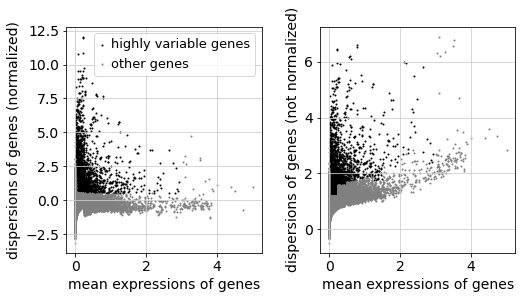

In [20]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [21]:
adata = adata[:, filter_result.gene_subset]

In [22]:
sc.pp.log1p(adata)

/home/ag16115/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
sc.pp.regress_out(adata, 'n_counts')

regressing out n_counts
    sparse input is densified and may lead to high memory use


/home/ag16115/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/ag16115/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


    finished (0:00:37)


In [24]:
sc.pp.scale(adata, max_value=10)

# PCA

In [25]:
adata.obs['clusters'] = labels
sc._utils.sanitize_anndata(adata)

In [26]:
list_labels =  np.unique(labels).tolist()

In [27]:
ordered_cats = list_labels

In [28]:
colors = {
 'Endoderm': 'purple',
 'Epidermal' : 'dodgerblue',
 'Forebrain / Optic' : 'lightsalmon',
 'Germline' : 'darkolivegreen',
 'Hindbrain / Spinal Cord' : 'firebrick',
 'Mesoderm' : 'teal',
 'Midbrain' : 'pink',
 'NaN' : '#8A8A8A',
 'Neural Crest': 'darkorange' ,
 'Other' : 'yellow',
 'Pluripotent': 'mediumorchid'
}

In [29]:
adata.uns['clusters_colors'] = [colors[clus] for clus in list(adata.obs['clusters'])]

In [30]:
Y = np.array(adata.to_df())
n,p = Y.shape

In [31]:
print(n,p)

5079 5498


In [ ]:
## dimension selection
# rmin = 1
# rmax = 50
# ws = wasserstein_dim_select(Y,rmin = rmin, rmax = rmax)
# dim = np.argmin(ws) + rmin
# print(f'Dimension selected: {dim}')

In [32]:
dim = 29

In [33]:
zeta = p**-.5 * pc_scores(Y, dim)

In [34]:
adata.obsm['PC_scores'] = zeta

In [1]:
# ## plot after applying PCA
# fig,ax = plt.subplots(1,1,figsize = (10,10))
# for t in ordered_cats:
#     idx = np.where(adata.obs['clusters'] == t)[0]
#     ax.scatter(zeta[idx,0],zeta[idx,1], marker = 'o',edgecolor='black', linewidth=0,s = 80,label = t,c= colors[t]);
# ax.set_title(f'PCA',fontsize=25)
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)

# ax.legend(loc='upper center', bbox_to_anchor=(1, -0.02),
#           fancybox=True, shadow=True, ncol=8)

# # fig.savefig(f"planaria.pdf", bbox_inches='tight')

# method comparison

In [ ]:
method_comparison_df = pd.DataFrame()

### inner products

In [ ]:
%%time
ip_clust = AgglomerativeClustering(affinity = ip_affinity, linkage = 'average',distance_threshold=0, n_clusters=None)
ip_clust.fit(zeta);

In [ ]:
%%time
ances = {}; desc = {}
ip_ranking = np.array([get_ranking(ip_clust,t) for t in range(n)])

ip_kt_z = [kendalltau(ip_ranking[i], true_ranking[i]).correlation for i in range(ip_ranking.shape[0])]
np.mean(ip_kt_z)

In [ ]:
%%time
ip_clust = AgglomerativeClustering(affinity = ip_affinity, linkage = 'average',distance_threshold=0, n_clusters=None)
ip_clust.fit(Y);

In [ ]:
%%time
ances = {}; desc = {}
ip_ranking = np.array([get_ranking(ip_clust,t) for t in range(n)])

ip_kt_y = [kendalltau(ip_ranking[i], true_ranking[i]).correlation for i in range(ip_ranking.shape[0])]
np.mean(ip_kt_y)

### ward

In [ ]:
%%time
ward = AgglomerativeClustering(linkage="ward", distance_threshold=0, n_clusters = None)
ward.fit(zeta)

In [ ]:
%%time
ances = {}; desc = {}
w_ranking = np.array([get_ranking(ward,t) for t in range(n)])

w_kt_z = [kendalltau(w_ranking[i], true_ranking[i]).correlation for i in range(w_ranking.shape[0])]
np.mean(w_kt_z)

In [ ]:
%%time
ward = AgglomerativeClustering(linkage="ward", distance_threshold=0, n_clusters = None)
ward.fit(Y)

In [ ]:
%%time
ances = {}; desc = {}
w_ranking = np.array([get_ranking(ward,t) for t in range(n)])

w_kt_y = [kendalltau(w_ranking[i], true_ranking[i]).correlation for i in range(w_ranking.shape[0])]
np.mean(w_kt_y)

### upgma

In [ ]:
%%time
average = AgglomerativeClustering(linkage="average", distance_threshold=0, n_clusters = None)
average.fit(zeta)

In [ ]:
%%time
ances = {}; desc  = {}
a_ranking = np.array([get_ranking(average,t) for t in range(n)])

a_kt_z = [kendalltau(a_ranking[i], true_ranking[i]).correlation for i in range(a_ranking.shape[0])]
np.mean(a_kt_z)

In [ ]:
sem(a_kt_z)

In [ ]:
%%time
average = AgglomerativeClustering(linkage="average", distance_threshold=0, n_clusters = None)
average.fit(Y)

In [ ]:
%%time
ances = {}; desc  = {}
a_ranking = np.array([get_ranking(average,t) for t in range(n)])

a_kt_y = [kendalltau(a_ranking[i], true_ranking[i]).correlation for i in range(a_ranking.shape[0])]
np.mean(a_kt_y)

### cosine

In [ ]:
%%time
cosine = AgglomerativeClustering(affinity = 'cosine', linkage = 'average', distance_threshold=0, n_clusters = None)
cosine.fit(zeta)

In [ ]:
%%time
ances = {}; desc  = {}
cs_ranking = np.array([get_ranking(cosine,t) for t in range(n)])

cs_kt_z = [kendalltau(cs_ranking[i], true_ranking[i]).correlation for i in range(cs_ranking.shape[0])]
np.mean(cs_kt_z)

In [ ]:
%%time
cosine = AgglomerativeClustering(affinity = 'cosine',linkage = 'average', distance_threshold=0, n_clusters = None)
cosine.fit(Y)

In [ ]:
%%time
ances = {}; desc  = {}
cs_ranking = np.array([get_ranking(cosine,t) for t in range(n)])

cs_kt_y = [kendalltau(cs_ranking[i], true_ranking[i]).correlation for i in range(cs_ranking.shape[0])]
np.mean(cs_kt_y)

In [ ]:
method_comparison_df['ip_sem'] = [sem(ip_kt_z),sem(ip_kt_y)]

method_comparison_df['ward_sem'] = [sem(w_kt_z),sem(w_kt_y)]

method_comparison_df['upgma	_sem'] = [sem(a_kt_z),sem(a_kt_y)]

method_comparison_df['cosine_sem'] = [sem(cs_kt_z),sem(cs_kt_y)]

In [ ]:
method_comparison_df['ip_z'] = [np.mean(ip_kt_z),sem(ip_kt_z)]
method_comparison_df['ip_y'] = [np.mean(ip_kt_y),sem(ip_kt_y)]

method_comparison_df['w_z'] = [np.mean(w_kt_z),sem(w_kt_z)]
method_comparison_df['w_y'] = [np.mean(w_kt_y),sem(w_kt_y)]

method_comparison_df['a_z'] = [np.mean(a_kt_z),sem(a_kt_z)]
method_comparison_df['a_y'] = [np.mean(a_kt_y),sem(a_kt_y)]

method_comparison_df['cs_z'] = [np.mean(cs_kt_z),sem(cs_kt_z)]
method_comparison_df['cs_y'] = [np.mean(cs_kt_y),sem(cs_kt_y)]

In [ ]:
# method_comparison_df.to_csv('method_comparison.csv', index=False)
# method_comparison_df

### hdbscan

In [ ]:
import hdbscan

In [ ]:
import sys
sys.setrecursionlimit(10000)

In [ ]:
hdbscan_ = hdbscan.HDBSCAN()
hdbscan_.fit(zeta)

hdbscan_.single_linkage_tree_;
hdbscan_.children_ = np.array(hdbscan_.single_linkage_tree_.to_pandas()[['left_child','right_child']], dtype=int)

In [ ]:
%%time
ances = {}; desc = {}
hdbscan_ranking = np.array([get_ranking(hdbscan_,t) for t in range(n)]) 

hdbscan_kt_z = [kendalltau(hdbscan_ranking[i], true_ranking[i]).correlation for i in range(hdbscan_ranking.shape[0])]
np.mean(hdbscan_kt_z)

In [ ]:
hdbscan_ = hdbscan.HDBSCAN()
hdbscan_.fit(Y)

hdbscan_.single_linkage_tree_;
hdbscan_.children_ = np.array(hdbscan_.single_linkage_tree_.to_pandas()[['left_child','right_child']], dtype=int)

In [ ]:
%%time
ances = {}; desc = {}
hdbscan_ranking = np.array([get_ranking(hdbscan_,t) for t in range(n)]) # range(n)

hdbscan_kt_y = [kendalltau(hdbscan_ranking[i], true_ranking[i]).correlation for i in range(hdbscan_ranking.shape[0])]
np.mean(hdbscan_kt_y)

In [ ]:
method_comparison_df['hdbscan_z'] = [np.mean(hdbscan_kt_z),sem(hdbscan_kt_z)]
method_comparison_df['hdbscan_y'] = [np.mean(hdbscan_kt_y),sem(hdbscan_kt_y)]

In [ ]:
method_comparison_df.to_csv('method_comparison_df.csv', index=False)

## Appendix method comparison

In [ ]:
linkage = ['complete','single']
metric = ['euclidean', 'cosine']
combs = list(itertools.product(linkage, metric))

In [ ]:
method_comparison_df_v2 = pd.DataFrame(columns = ['linkage','metric',
                                                  'zeta_mean','zeta_se','Y_mean','Y_se'])

In [ ]:
for i in range(len(combs)):
    print(combs[i])
    
    on_zeta = AgglomerativeClustering(affinity = combs[i][1], linkage = combs[i][0],distance_threshold=0, n_clusters=None)
    on_zeta.fit(zeta);
    ances = {}; desc = {}
    on_zeta_ranking = np.array([get_ranking(on_zeta,t) for t in range(n)])
    kt_z = [kendalltau(on_zeta_ranking[i], true_ranking[i]).correlation for i in range(on_zeta_ranking.shape[0])]
    
    on_Y = AgglomerativeClustering(affinity = combs[i][1], linkage = combs[i][0],distance_threshold=0, n_clusters=None)
    on_Y.fit(Y);
    ances = {}; desc = {}
    on_Y_ranking = np.array([get_ranking(on_Y,t) for t in range(n)])
    kt_Y = [kendalltau(on_Y_ranking[i], true_ranking[i]).correlation for i in range(on_Y_ranking.shape[0])]
    
    
    new_row = {'linkage': combs[i][0],'metric':combs[i][1],
               'zeta_mean': np.mean(kt_z),'zeta_se': sem(kt_z),
               'Y_mean': np.mean(kt_Y),'Y_se': sem(kt_Y)}
    method_comparison_df_v2 = pd.concat([method_comparison_df_v2,pd.DataFrame(new_row, index=[0])]).reset_index(drop=True)

In [ ]:
method_comparison_df_v2.to_csv('method_comparison_v2.csv', index=False)